# 오디오 분류(Audio Classification)

* 가상 악기를 활용해 악기별 음색 데이터셋을 활용해 오디오 분류

1. 기존 데이터에서 분류에 사용되는 방법을 사용해 분류
2. 오디오 데이터에 특화된 분류

* 출처: https://bab2min.tistory.com/642

### 데이터 준비 및 전처리

In [1]:
import numpy as np
import itertools
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')


* 데이터를 저장할 리스트와 파일을 불러올 경로를 지정

* http://suanlab.com/datasets/GeneralMidi.wav



In [2]:
!wget http://suanlab.com/datasets/GeneralMidi.wav

--2022-09-14 02:22:17--  http://suanlab.com/datasets/GeneralMidi.wav
Resolving suanlab.com (suanlab.com)... 52.219.146.52
Connecting to suanlab.com (suanlab.com)|52.219.146.52|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3409459756 (3.2G) [audio/wav]
Saving to: ‘GeneralMidi.wav’

GeneralMidi.wav     100%[===================>]   3.17G  16.0MB/s    in 3m 23s  

2022-09-14 02:25:41 (16.0 MB/s) - ‘GeneralMidi.wav’ saved [3409459756/3409459756]



In [3]:
midi_file = "./GeneralMidi.wav"

* wmv 파일에는 128개 악기와 46개 타악기의 음을 50개씩 2초 간격으로 존재
* 해당 예제에서는 일부 악기만 선택해서 사용

In [4]:
instruments = [0, 10, 20,30,40,50,60,70,80,90]
num_notes = 50
sec = 2

audio = []
inst = []
for inst_idx, note in itertools.product(range(len(instruments)), range(num_notes)):
  instrument = instruments[inst_idx]
  offset = (instrument*num_notes*sec) + (note*sec)
  print('instrument: {}, note: {}, offset: {}'.format(instrument, note, offset))
  y, sr = librosa.load(midi_file, sr=None, offset=offset, duration=2.0)
  audio.append(y)
  inst.append(inst_idx)

instrument: 0, note: 0, offset: 0
instrument: 0, note: 1, offset: 2
instrument: 0, note: 2, offset: 4
instrument: 0, note: 3, offset: 6
instrument: 0, note: 4, offset: 8
instrument: 0, note: 5, offset: 10
instrument: 0, note: 6, offset: 12
instrument: 0, note: 7, offset: 14
instrument: 0, note: 8, offset: 16
instrument: 0, note: 9, offset: 18
instrument: 0, note: 10, offset: 20
instrument: 0, note: 11, offset: 22
instrument: 0, note: 12, offset: 24
instrument: 0, note: 13, offset: 26
instrument: 0, note: 14, offset: 28
instrument: 0, note: 15, offset: 30
instrument: 0, note: 16, offset: 32
instrument: 0, note: 17, offset: 34
instrument: 0, note: 18, offset: 36
instrument: 0, note: 19, offset: 38
instrument: 0, note: 20, offset: 40
instrument: 0, note: 21, offset: 42
instrument: 0, note: 22, offset: 44
instrument: 0, note: 23, offset: 46
instrument: 0, note: 24, offset: 48
instrument: 0, note: 25, offset: 50
instrument: 0, note: 26, offset: 52
instrument: 0, note: 27, offset: 54
instrum

In [5]:
import numpy as np

audio_np = np.array(audio, np.float32)
inst_np = np.array(inst, np.int16)

print(audio_np.shape, inst_np.shape)

(500, 88200) (500,)


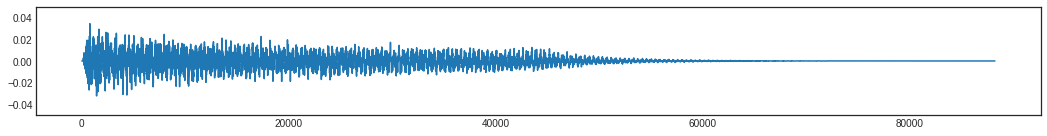

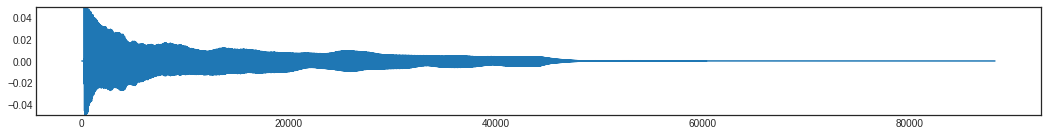

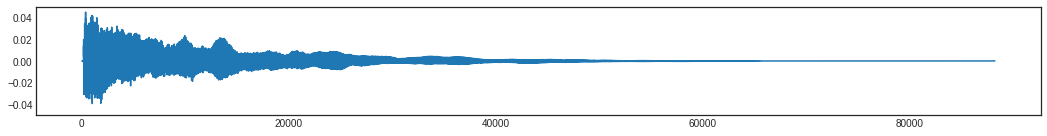

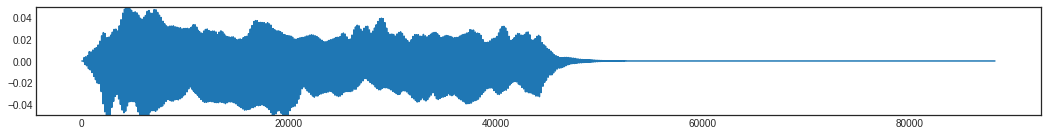

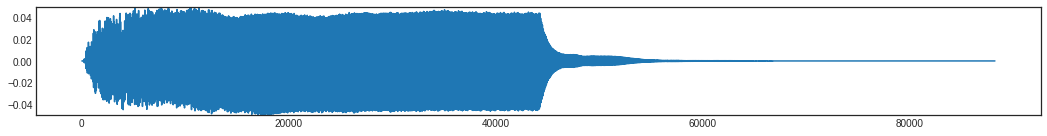

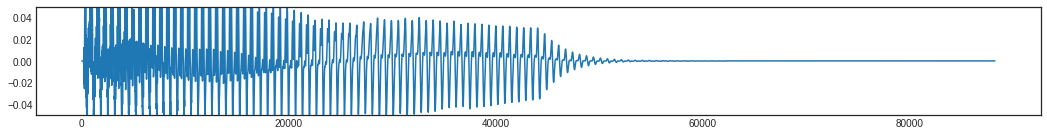

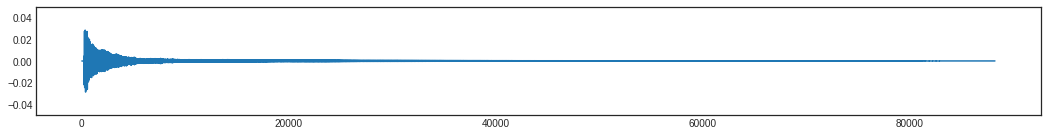

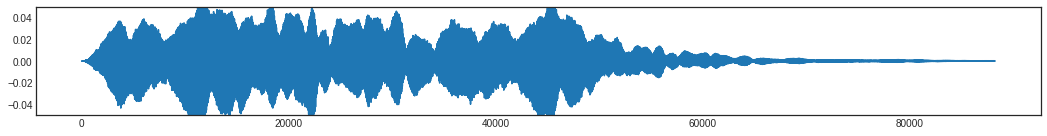

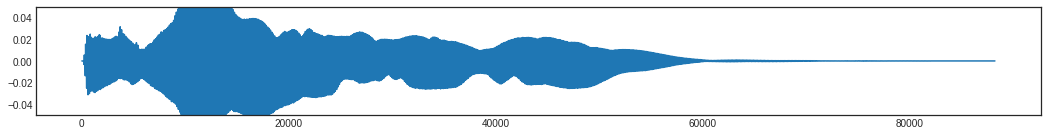

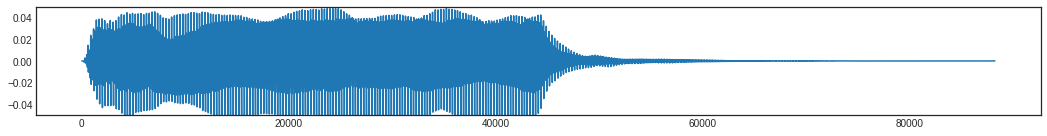

In [6]:
for idx in range(0, len(audio_np), num_notes):
  plt.figure(figsize=(18,2))
  plt.plot(audio_np[idx])
  plt.ylim((-0.05, 0.05))
  plt.show()

In [7]:
print(inst_np[0])
ipd.Audio(audio_np[0], rate=sr)

0


In [8]:
print(inst_np[50])
ipd.Audio(audio_np[50], rate=sr)

1


In [9]:
print(inst_np[100])
ipd.Audio(audio_np[100], rate=sr)

2


In [10]:
print(inst_np[150])
ipd.Audio(audio_np[150], rate=sr)

3


In [11]:
print(inst_np[200])
ipd.Audio(audio_np[200], rate=sr)

4


In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(audio_np)

MinMaxScaler()

## 머신러닝을 이용한 오디오 분류

* 학습 데이터와 실험 데이터를 분리

In [13]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(audio_np, inst_np, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 88200)
(100, 88200)
(400,)
(100,)


### Logistic Regression

* Logistic Regression은 특성상 다중 분류에는 적합하지 않음

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR=LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.07


### Support Vector Machine

In [15]:
from sklearn import svm

SVM = svm.SVC(kernel='linear')
SVM.fit(train_x, train_y)
pred=SVM.predict(test_x)
acc= accuracy_score(pred, test_y)
print(acc)

0.07


### Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred =DT.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.38


## Constant-Q를 이용한 머신러닝 오디오 분류

### 데이터 준비

* wav는 매 순간의 음압을 측정하여 그 수치를 저장한 형태이기 때문에 그 자체로 음악을 분석하기에 적합하지 않음 (음의 높이와 세기를 듣는것이지 순간의 음압을 듣는게 아니기 때문)
* 푸리에 변환과 같은 변환 기법을 이용하여 시간 축의 데이터를 주파수 축의 데이터로 바꿔줘야할 필요가 있음
* 푸리에 변환 대신 푸리에 변환과 유사한 Constant-Q 변환을 사용
* Constant-Q 변환은 주파수 축이 로그 단위로 변환되고, 각 주파수에 따라 해상도가 다양하게 처리되기 때문에(저주파는 저해상도, 고주파는 고해상도) 음악을 처리하는 데에 푸리에 변환보다 유리

*   주파수 대역을 저장할 리스트 `audio_cqt` 선언
*   constant-Q 변환할 때는 변환할 오디오 데이터와 sampling rate가 필요
*   해당 데이터에서는 sampling rate가 모두 동일하므로 따로 처리가 필요하지 않음
*   여기서는 Constant-Q 변환을 사용해 오디오 데이터를 주파수 대역으로 변환




*   변환에는 앞서 준비한 데이터를 가져와 사용하며, Constant-Q 변환에는 `librosa.cqt` 함수를 사용
*   여기서 `n_bins`는 옥타브 단계 및 개수를, `bins_per_octave`는 한 옥타브가 가지는 단계를 의미
*   라벨에 대해선 원 핫 인코딩을 적용



In [17]:
audio_cqt = []
for y in audio:
  ret = librosa.cqt(y, sr, hop_length=1024, n_bins=24*7, bins_per_octave=24)
  ret = np.abs(ret)
  audio_cqt.append(ret)

* 앞서 생성한 주파수 대역을 spectrogram으로 시각화
* 악기 간 spectrogram을 비교해보면 차이가 존재함을 알 수 있음

/usr/local/lib/python3.7/dist-packages/librosa/display.py:1336: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  "Frequency axis exceeds Nyquist. "


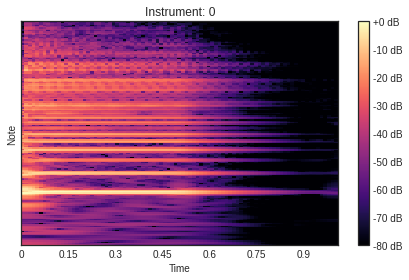

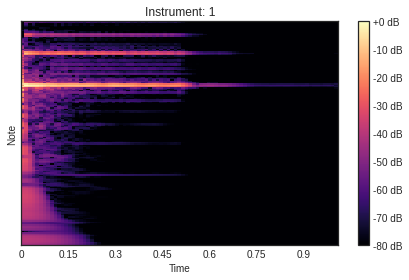

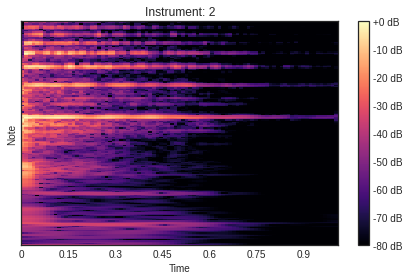

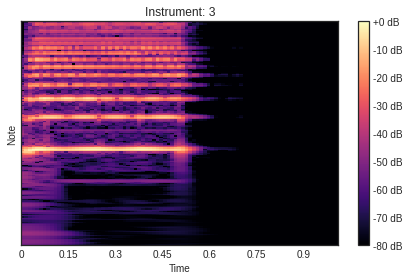

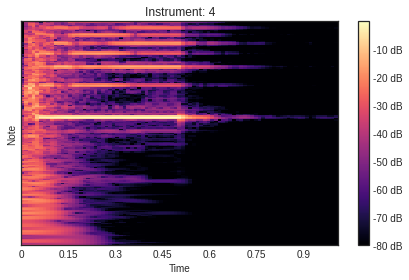

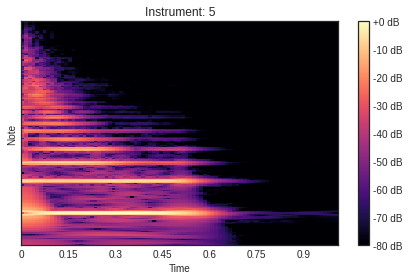

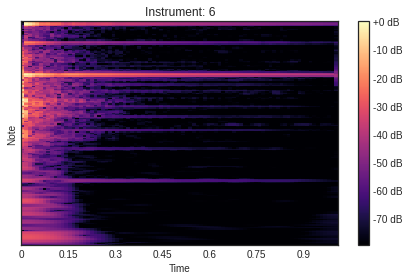

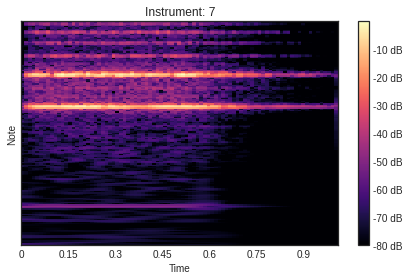

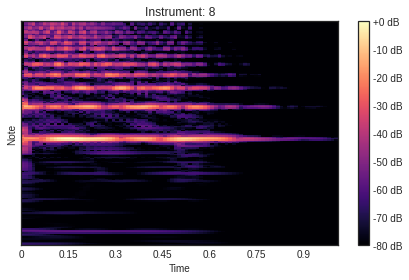

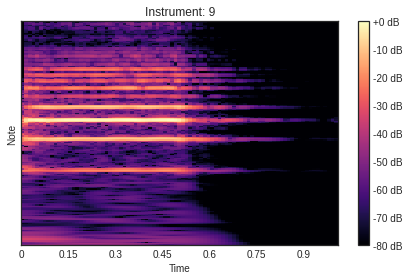

In [18]:
for i in range(0, len(instruments) * num_notes, num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_cqt[i]), ref=np.max)
  librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Instrument: {}'.format(inst[i]))
  plt.tight_layout()
  plt.show()


* 훈련 데이터와 실험 데이터를 분리

In [19]:
cqt_np = np.array(audio_cqt, np.float32)
inst_np = np.array(inst, np.int16)

print(cqt_np.shape, inst_np.shape)

(500, 168, 87) (500,)




*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환



In [20]:
cqt_np = cqt_np.reshape((500, 168 * 87))



*   읽어온 데이터는 음량이나 범위가 다를 수 있음
*   min-max scaling을 통해 데이터의 범위를 조정함



In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(cqt_np)

MinMaxScaler()

* 학습 데이터와 실험 데이터를 분리

In [22]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(cqt_np, inst_np, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 14616)
(100, 14616)
(400,)
(100,)


### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR=LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.25


### Support Vector Machine

In [24]:
from sklearn import svm

SVM = svm.SVC(kernel='linear')
SVM.fit(train_x, train_y)
pred=SVM.predict(test_x)
acc= accuracy_score(pred, test_y)
print(acc)

0.37


### Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred =DT.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.61


## Constant-Q 특징을 이용한 딥러닝 오디오 분류

* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### DNN 모델 구성

In [26]:
from tensorflow.keras.utils import to_categorical

cqt_np = np.array(audio_cqt, np.float32)
cqt_np = cqt_np.reshape((500, 168*87))
cqt_array = np.expand_dims(cqt_np, -1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(cqt_array, inst_cat, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 14616, 1)
(100, 14616, 1)
(400, 10)
(100, 10)


In [47]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense

def model_build():
  model = Sequential()

  input = Input(shape=(14616,), name='input')
  output =Dense(128, activation='relu', name='hidden1')(input)
  output = Dense(64, activation='relu', name='hidden2')(output)
  output = Dense(10, activation = 'softmax', name='output')(output)

  model = Model(inputs=[input], outputs = output)

  model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['acc'])

  return model

In [48]:
model = model_build()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 14616)]           0         
                                                                 
 hidden1 (Dense)             (None, 128)               1870976   
                                                                 
 hidden2 (Dense)             (None, 64)                8256      
                                                                 
 output (Dense)              (None, 10)                650       
                                                                 
Total params: 1,879,882
Trainable params: 1,879,882
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = model.fit(train_x, train_y, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 1s 103ms/step - loss: 2.2886 - acc: 0.1125 - val_loss: 2.1187 - val_acc: 0.1500
Epoch 2/30
3/3 [==============================] - 0s 35ms/step - loss: 2.0042 - acc: 0.4156 - val_loss: 1.9885 - val_acc: 0.3375
Epoch 3/30
3/3 [==============================] - 0s 34ms/step - loss: 1.8095 - acc: 0.5406 - val_loss: 1.9080 - val_acc: 0.2750
Epoch 4/30
3/3 [==============================] - 0s 43ms/step - loss: 1.6398 - acc: 0.5719 - val_loss: 1.8564 - val_acc: 0.2875
Epoch 5/30
3/3 [==============================] - 0s 34ms/step - loss: 1.4852 - acc: 0.6344 - val_loss: 1.8098 - val_acc: 0.3000
Epoch 6/30
3/3 [==============================] - 0s 33ms/step - loss: 1.3451 - acc: 0.6719 - val_loss: 1.7829 - val_acc: 0.2750
Epoch 7/30
3/3 [==============================] - 0s 33ms/step - loss: 1.2164 - acc: 0.6969 - val_loss: 1.7702 - val_acc: 0.3000
Epoch 8/30
3/3 [==============================] - 0s 35ms/step - loss: 1.1010 - acc: 0.7344 - va

In [60]:
def plot_history(history_dict):
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(loss) + 1)
  fig = plt.figure(figsize=(14,5))

  ax1 = fig.add_subplot(1,2,1)
  ax1.plot(epochs, loss, 'b--', label='train_loss')
  ax1.plot(epochs, val_loss, 'r:', label='val_loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.grid()
  ax1.legend()

  acc = history_dict['acc']
  val_acc = history_dict['val_acc']

  ax2 = fig.add_subplot(1,2,2)
  ax2.plot(epochs, acc,'b--', label='train_accuracy')
  ax2.plot(epochs, val_acc, 'r:', label='val_accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.grid()
  ax2.legend()

  plt.show()


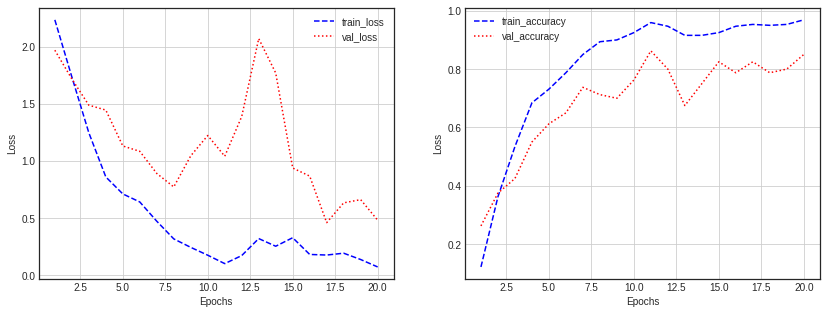

In [61]:
plot_history(history.history)

In [52]:
model.evaluate(test_x, test_y)

4/4 [==============================] - 0s 5ms/step - loss: 3.5741 - acc: 0.3600


[3.57407808303833, 0.36000001430511475]

### CNN 모델 구성



*   spectrogram을 분류할 CNN 모델 구성
*   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
*   spectrogram은 1차원 이미지로 간주


In [57]:
from tensorflow.keras.utils import to_categorical

cqt_np = np.array(audio_cqt, np.float32)

cqt_array = np.expand_dims(cqt_np, -1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(cqt_array, inst_cat, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 168, 87, 1)
(100, 168, 87, 1)
(400, 10)
(100, 10)


In [54]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten

def model_build():
  model=Sequential()

  input = Input(shape=(168, 87, 1))

  output = Conv2D(128, 3, strides=1, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(256, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(512, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Flatten()(output)
  output = Dense(512, activation='relu')(output)
  output = Dense(256, activation = 'relu')(output)
  output = Dense(128, activation='relu')(output)

  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs = output)

  model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['acc'])

  return model

In [58]:
model = model_build()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 168, 87, 1)]      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 168, 87, 128)      1280      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 84, 44, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 84, 44, 256)       295168    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 42, 22, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 42, 22, 512)       1180

In [59]:
history = model.fit(train_x, train_y, epochs=20, batch_size=128, validation_split = 0.2 )

Epoch 1/20
3/3 [==============================] - 84s 25s/step - loss: 2.2352 - acc: 0.1219 - val_loss: 1.9694 - val_acc: 0.2625
Epoch 2/20
3/3 [==============================] - 88s 28s/step - loss: 1.7367 - acc: 0.3625 - val_loss: 1.7186 - val_acc: 0.3750
Epoch 3/20
3/3 [==============================] - 82s 26s/step - loss: 1.2473 - acc: 0.5344 - val_loss: 1.4886 - val_acc: 0.4250
Epoch 4/20
3/3 [==============================] - 81s 25s/step - loss: 0.8607 - acc: 0.6844 - val_loss: 1.4458 - val_acc: 0.5500
Epoch 5/20
3/3 [==============================] - 80s 25s/step - loss: 0.7121 - acc: 0.7312 - val_loss: 1.1316 - val_acc: 0.6125
Epoch 6/20
3/3 [==============================] - 82s 25s/step - loss: 0.6416 - acc: 0.7875 - val_loss: 1.0847 - val_acc: 0.6500
Epoch 7/20
3/3 [==============================] - 89s 28s/step - loss: 0.4730 - acc: 0.8500 - val_loss: 0.8912 - val_acc: 0.7375
Epoch 8/20
3/3 [==============================] - 81s 25s/step - loss: 0.3186 - acc: 0.8938 - val

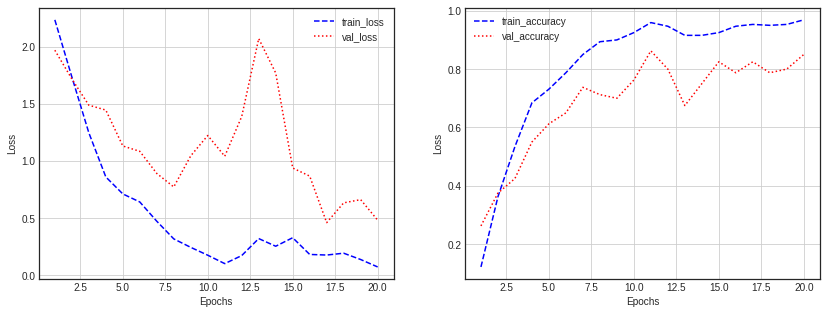

In [62]:
plot_history(history.history)



*   훈련한 모델에 대한 정확도 평가
*   앞선 일반 분류 방법보다 정확도가 많이 오른 것을 확인할 수 있음



In [63]:
model.evaluate(test_x, test_y)

4/4 [==============================] - 7s 2s/step - loss: 0.4243 - acc: 0.8900


[0.42429473996162415, 0.8899999856948853]

## MFCC를 이용한 머신러닝 오디오 분류

### 데이터 준비

* 데이터를 불러오고 MFCC(Mel-frequency cepstral coefficients)를 사용해 melspectrogram으로 변환

In [64]:
audio_mfcc = []
for y in audio:
  ret = librosa.feature.mfcc(y=y, sr=sr)
  audio_mfcc.append(ret)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9839 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9839 missing from current font.
  font.set_text(s, 0, flags=flags)


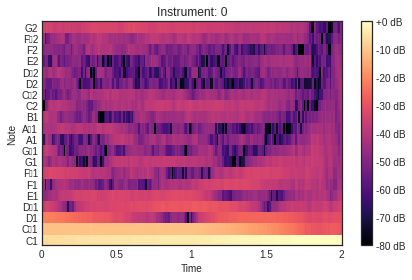

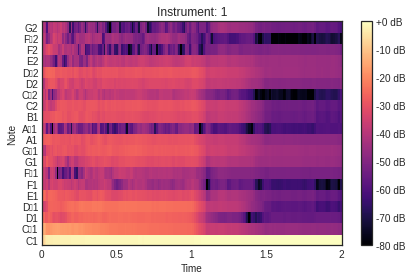

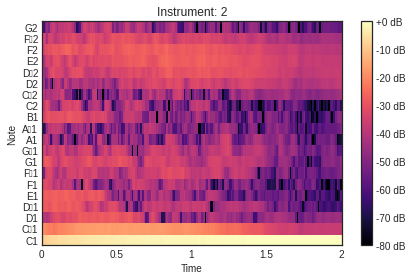

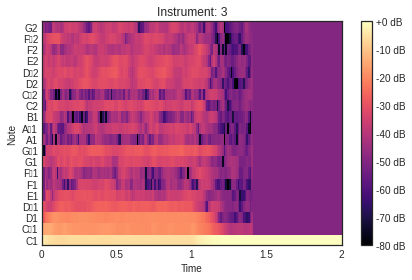

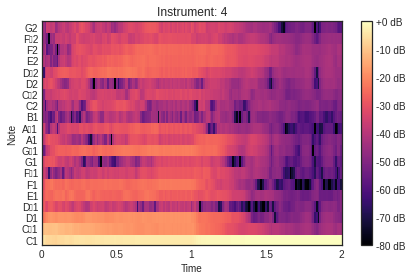

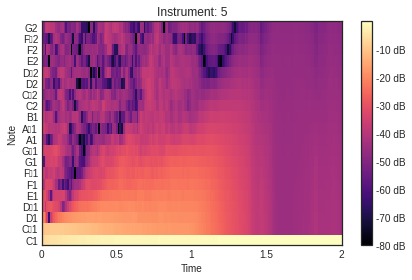

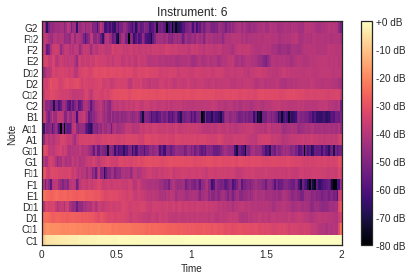

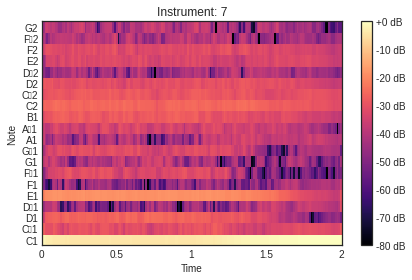

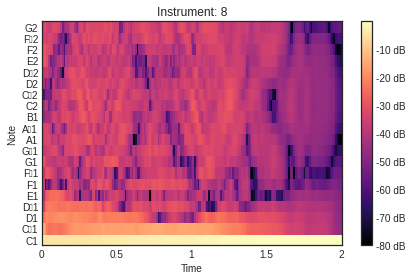

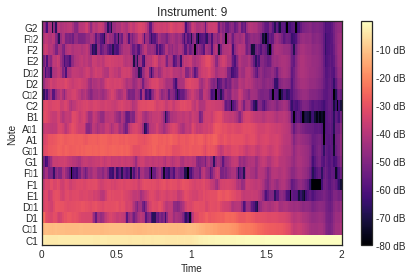

In [66]:
for i in range(0, len(instruments)*num_notes, num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_mfcc[i]), ref=np.max)
  librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Instrument: {}'.format(inst[i]))
  plt.tight_layout()
  plt.show()

In [68]:
mfcc_np = np.array(audio_mfcc, np.float32)
inst_np = np.array(inst, np.int16)

print(mfcc_np.shape, inst_np.shape)

(500, 20, 173) (500,)




*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환



In [69]:
mfcc_np = mfcc_np.reshape((500,20*173))



*   읽어온 데이터는 음량이나 범위가 다를 수 있음
*   min-max scaling을 통해 데이터의 범위를 조정함



In [70]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(mfcc_np)


MinMaxScaler()

* 학습 데이터와 실험 데이터를 분리

In [71]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(mfcc_np, inst_np, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 3460)
(100, 3460)
(400,)
(100,)


### Logistic Regression

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR=LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.95


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### Support Vector Machine

In [73]:
from sklearn import svm

SVM = svm.SVC(kernel='linear')
SVM.fit(train_x, train_y)
pred=SVM.predict(test_x)
acc= accuracy_score(pred, test_y)
print(acc)

0.98


### Decision Tree

In [74]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred =DT.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.89


## MFCC를 이용한 딥러닝 오디오 분류

* 앞선 문제점을 극복하기 위해 오디오 데이터에 특화된 분류 방법 필요
* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### DNN 모델 구성

In [78]:
from tensorflow.keras.utils import to_categorical

mfcc_np = np.array(audio_mfcc, np.float32)
mfcc_array = np.expand_dims(mfcc_np, -1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(mfcc_array, inst_cat, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 20, 173, 1)
(100, 20, 173, 1)
(400, 10)
(100, 10)


In [79]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten

def model_build():
  model=Sequential()

  input = Input(shape=(20, 173, 1))

  output = Conv2D(128, 3, strides=1, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(256, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(512, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Flatten()(output)
  output = Dense(512, activation='relu')(output)
  output = Dense(256, activation = 'relu')(output)
  output = Dense(128, activation='relu')(output)

  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs = output)

  model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['acc'])

  return model

In [81]:
model = model_build()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 20, 173, 1)]      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 20, 173, 128)      1280      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 10, 87, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 10, 87, 256)       295168    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 5, 44, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 5, 44, 512)        1180

In [82]:
history = model.fit(train_x, train_y, epochs=20, batch_size=128, validation_split = 0.2 )

Epoch 1/20
3/3 [==============================] - 21s 6s/step - loss: 64.0592 - acc: 0.0875 - val_loss: 49.1286 - val_acc: 0.1625
Epoch 2/20
3/3 [==============================] - 22s 7s/step - loss: 27.5976 - acc: 0.0719 - val_loss: 3.5552 - val_acc: 0.1000
Epoch 3/20
3/3 [==============================] - 20s 6s/step - loss: 2.9386 - acc: 0.1031 - val_loss: 2.3525 - val_acc: 0.1000
Epoch 4/20
3/3 [==============================] - 20s 6s/step - loss: 2.2519 - acc: 0.1500 - val_loss: 2.1795 - val_acc: 0.1875
Epoch 5/20
3/3 [==============================] - 20s 6s/step - loss: 2.1136 - acc: 0.2406 - val_loss: 1.8690 - val_acc: 0.3875
Epoch 6/20
3/3 [==============================] - 21s 7s/step - loss: 1.8065 - acc: 0.3719 - val_loss: 1.5187 - val_acc: 0.4500
Epoch 7/20
3/3 [==============================] - 20s 6s/step - loss: 1.4629 - acc: 0.5375 - val_loss: 1.1676 - val_acc: 0.6500
Epoch 8/20
3/3 [==============================] - 20s 6s/step - loss: 1.0224 - acc: 0.6875 - val_loss

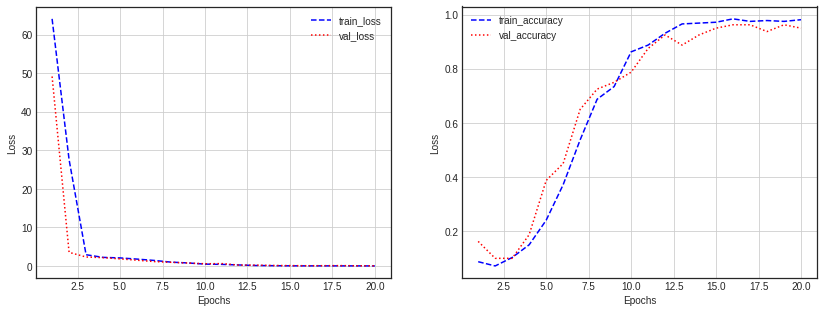

In [83]:
plot_history(history.history)

In [84]:
model.evaluate(test_x, test_y)

4/4 [==============================] - 2s 375ms/step - loss: 0.0129 - acc: 1.0000


[0.012893639504909515, 1.0]

### CNN 모델 구성



*   spectrogram을 분류할 CNN 모델 구성
*   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
*   spectrogram은 1차원 이미지로 간주
